# This notebook is to perform ML on embedded subnetworks and use the important features to find critical genes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
from src.eda.process_phenotype import *
from src.eda.eda_functions import run_kmeans, cluster_phenotype_corr, plot_corr_kde
from src.eda.eda_functions_extra import gene_set_phenotype_corr, plot_dist
from src.models.feature_extraction import *
from src.models.ML_functions import *
from scipy.stats import f_oneway
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

# Load embedding dfs

### Docker Machine learning models

In [2]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16/embedded_ggvec_epoch=100_alpha=0.1.csv'
emb_df = pd.read_csv(embedding_path, index_col = 0)
emb_name = 'epoch=100_alpha=0.1'
kmeans = run_kmeans(emb_df, 10)

Wall time: 1.69 s


In [3]:
deseq = pd.read_excel(prefix +'/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [ ]:
import umap

In [39]:
# determine the best umap parameter
umap_deseq_dfs = []
for n in [3,10,20]:
    for dist in [0.5,1]:
        reducer = umap.UMAP(n_neighbors = n, min_dist = dist, random_state = 42, init='random')
        umap_embedding = reducer.fit_transform(emb_df)
        umap_df = pd.DataFrame(umap_embedding)
        umap_df.index = emb_df.index
        umap_w_deseq = pd.merge(umap_df, deseq, left_index = True, right_on = 'id')
        umap_deseq_dfs.append(umap_w_deseq)

In [85]:
def plot_umap_w_deseq(umap_w_deseq):
    plt.rcParams.update({'font.size':24})
    plt.figure(figsize = (6,5))
    plt.scatter(umap_w_deseq[0], umap_w_deseq[1], color = 'lightgray', s = 1)
    plt.scatter(umap_w_deseq[umap_w_deseq.log2FoldChange > 0.1][0], umap_w_deseq[umap_w_deseq.log2FoldChange > 0.1][1], s = 2, label = 'up')
    plt.scatter(umap_w_deseq[umap_w_deseq.log2FoldChange < -0.1][0], umap_w_deseq[umap_w_deseq.log2FoldChange < -0.1][1], s = 2, color = 'r', label = 'down')
    lg = plt.legend(markerscale = 5, bbox_to_anchor=(0.8, 0.7))
    lg.get_frame().set_alpha(None)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

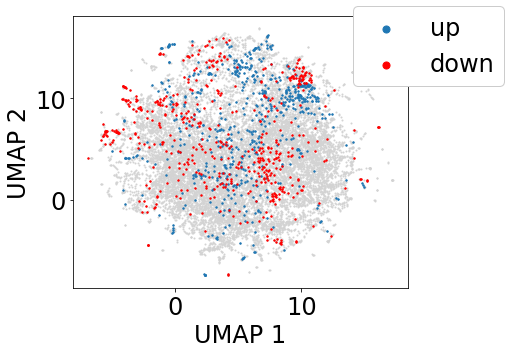

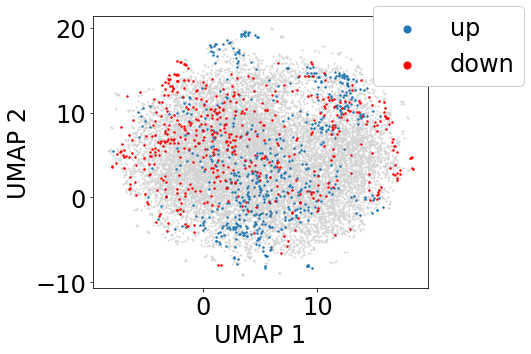

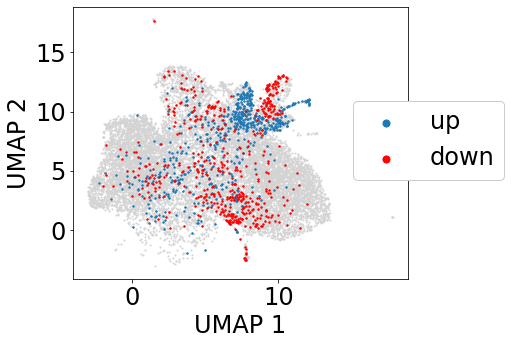

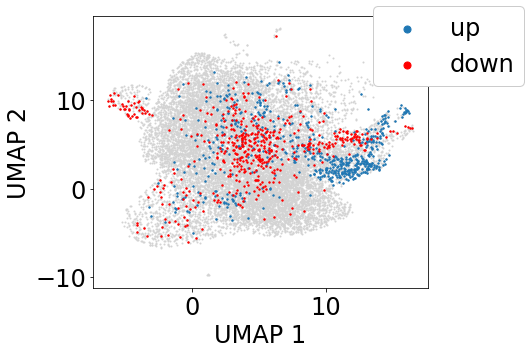

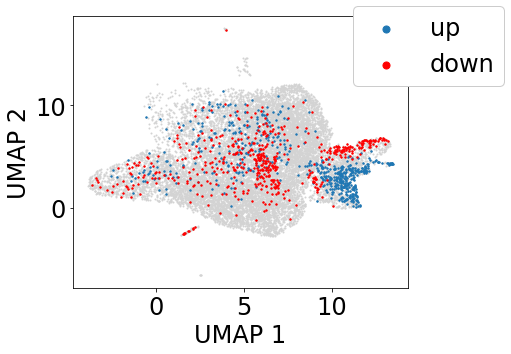

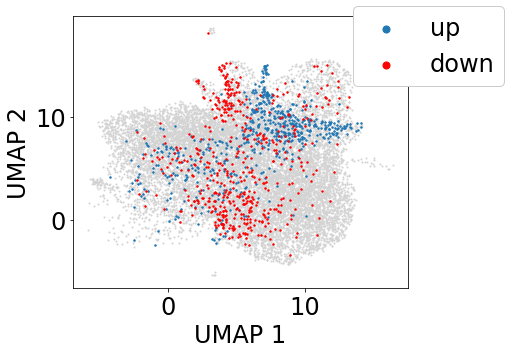

In [87]:
for umap_w_deseq in umap_deseq_dfs:
    plot_umap_w_deseq(umap_w_deseq)

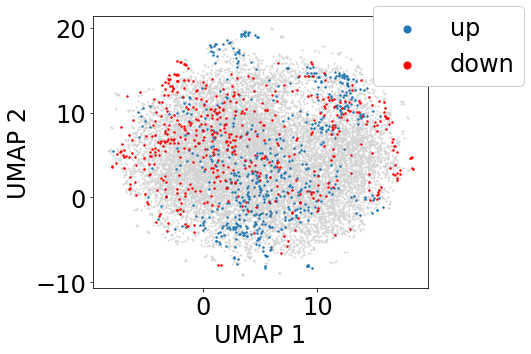

In [86]:
plot_umap_w_deseq(umap_deseq_dfs[1])

In [4]:
%%time
# process embedding to be ready for ML
processed_emb_df = process_emb_for_ML(emb_df, deseq)

Wall time: 24 ms


# Run ML on each embedding (5 embedding total), 3 models each and each model was repeated 3 times so a total of 5 x 3 x 3 = 45 results

### Docker Machine learning models

lr average: 52 ;  rf average: 75 ;  xgb_average: 76
Removing existing folder: output
Created folder output


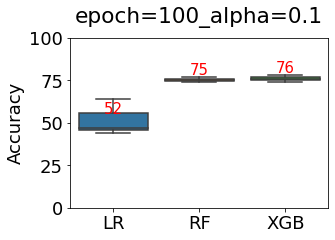

In [5]:
model_weights = run_ml(processed_emb_df, emb_name = emb_name, print_accuracy = True)

# Getting the feature importances and the dimensions that make up 20% of feature importances

### Docker Feature Extraction

In [6]:
top_dim = plot_feature_importances(model_weights, top_n_coef = 0.5, print_num_dim = False, plot_heatmap = False, return_top_dim = True)

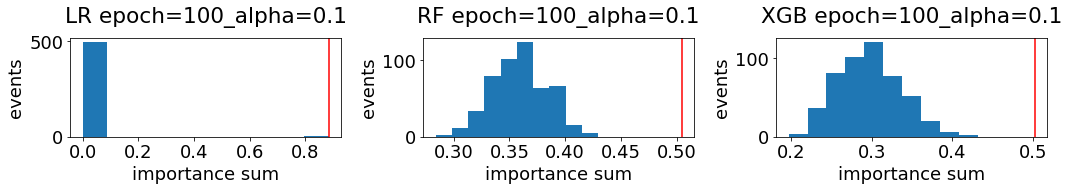

In [7]:
plot_random_feature_importance(model_weights, top_dim, emb_name)

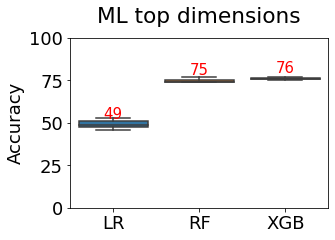

In [7]:
plot_ml_w_top_dim(processed_emb_df, top_dim)

## Determine jaccard similarity between the "important dimensions" for the repeats of the model

### Docker Feature Extraction

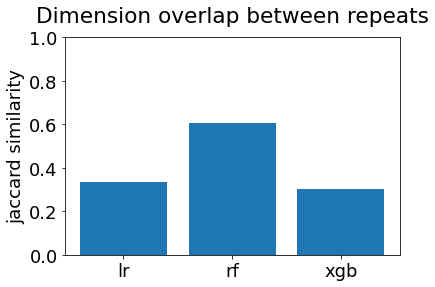

In [130]:
jaccard_average(top_dim, 'Dimension overlap between repeats')

# Identify critical genes from the parameters used (3 models, 3 repeats)

### Docker Critical Gene Identifier

In [228]:
%%time 
output_path = prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/'
critical_gene_df = get_critical_gene_df(processed_emb_df, top_dim, deseq = deseq, output_path = output_path, aimed_number = 500, within_n = 30, models = ['RF', 'XGB'])

Wall time: 0 ns


In [279]:
intersect_genes = jaccard_critical_genes(critical_gene_df, 'Critical gene overlap between models')

critical gene overlap between models ['RF vs XGB'] is 0.538


## Plot correlation of sets of critical genes found in common in 3 models for each embedding

### Module DE/ Diagnostic Correlation (second one)

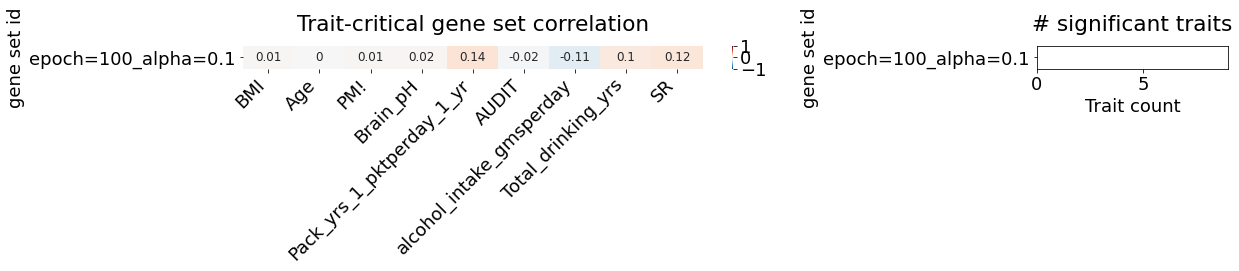

In [27]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)
gene_set_phenotype_corr([intersect_genes], [emb_name], expression_meta_df, 'intersect genes between 3 models')

## Plot number of nearby impact genes to the critical genes. 1 figure per embedding

### Docker Critical Gene Identifier

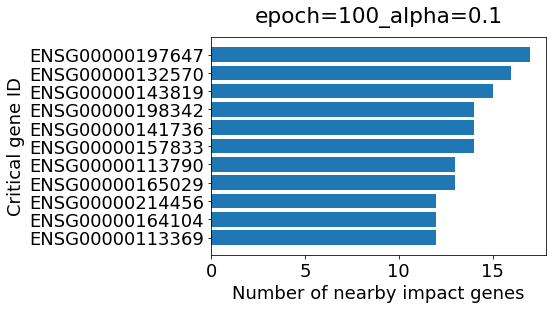

In [31]:
critical_gene_set2 = plot_nearby_impact_num(critical_gene_df, emb_name)

In [91]:
critical_gene_df.head()

,gene,LR_repeat1,LR_repeat2,LR_repeat3,RF_repeat1,RF_repeat2,RF_repeat3,XGB_repeat1,XGB_repeat2,XGB_repeat3,near_impact_cnt
0,ENSG00000197647,0.0,0.0,3.0,2.0,2.0,2.0,3.0,2.0,3.0,17.0
1,ENSG00000132570,1.0,1.0,2.0,4.0,2.0,2.0,1.0,2.0,1.0,16.0
2,ENSG00000143819,0.0,0.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,15.0
3,ENSG00000157833,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,14.0
4,ENSG00000141736,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,14.0


In [7]:
processed_important_emb_df = processed_emb_df[top_dim[5]]
pairwise_distances = pd.DataFrame(ed(processed_important_emb_df.iloc[:, :-2]))
pairwise_distances.columns = processed_emb_df['id']
pairwise_distances.index = processed_emb_df['id']
pairwise_distances['abs_log2FC'] = processed_emb_df['abs_log2FC'].tolist()
pairwise_distances.sort_values('abs_log2FC', ascending = False, inplace=True)

In [41]:
pairwise_distances[['ENSG00000197647','abs_log2FC']]

id,ENSG00000197647,abs_log2FC
id,,
ENSG00000196169,0.524583,3.122151e-01
ENSG00000166819,0.214590,2.899217e-01
ENSG00000138741,0.406802,2.857375e-01
ENSG00000096060,0.281973,2.799149e-01
ENSG00000139144,0.350841,2.782902e-01
...,...,...
ENSG00000025156,0.390886,2.250564e-05
ENSG00000102934,0.718724,1.045304e-05
ENSG00000153395,0.411740,9.038551e-06


In [8]:
pairwise_distances[(pairwise_distances['ENSG00000139144'] < 0.1) & (pairwise_distances['abs_log2FC'] > 0.2)]['ENSG00000197647'].index

Index(['ENSG00000139144'], dtype='object', name='id')

In [13]:
def plot_critical_gene_2D(dim1, dim2, pairwise_distance_df, critical_gene, distance = 0.15, de_cutoff = 0.2):
    plt.figure(figsize = (8,6))
    plt.scatter(emb_df[dim1], emb_df[dim2], color = 'lightgrey', s = 2)
    plt.rcParams.update({'font.size':26})
    i = 0
    for gene in pairwise_distance_df[(pairwise_distance_df[critical_gene] < distance) & (pairwise_distance_df['abs_log2FC'] > de_cutoff)][critical_gene].index:
        plt.scatter(emb_df.loc[gene, dim1], emb_df.loc[gene, dim2], s = 100, color = 'b', label="impact" if i == 0 else "")
        i += 1
    plt.scatter(emb_df.loc[critical_gene, dim1], emb_df.loc[critical_gene, dim2], color = 'r', s = 200, marker = '*', label = 'CG')
    leg = plt.legend(loc='center left', bbox_to_anchor=(0.6, 0.85))
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    leg.get_frame().set_alpha(None)

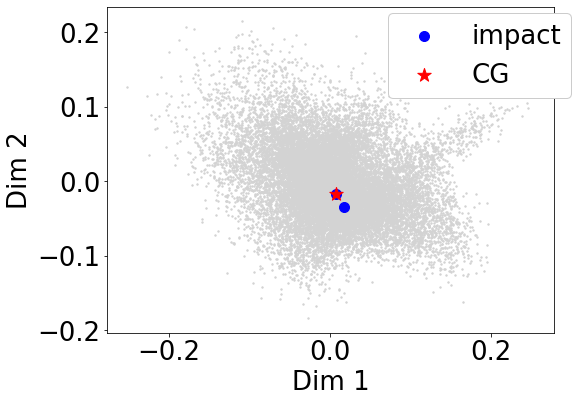

In [14]:
plot_critical_gene_2D('12','50', pairwise_distances, 'ENSG00000139144', distance = 0.1, de_cutoff = 0.15)

In [ ]:
plt.scatter(emb_df['12'], emb_df['50'], color = 'lightgrey', s = 2)
for gene in pairwise_distances[(pairwise_distances['ENSG00000132570'] < 0.1) & (pairwise_distances['abs_log2FC'] > 0.2)]['ENSG00000132570'].index:
    plt.scatter(emb_df.loc[gene, '12'], emb_df.loc[gene, '50'], s = 5, color = 'b')
plt.scatter(emb_df.loc['ENSG00000132570', '12'], emb_df.loc['ENSG00000132570', '50'], color = 'r', s = 30, marker = '*')

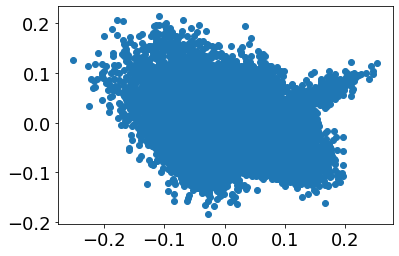

In [26]:
plt.scatter(emb_df['12'], emb_df['50'])

## Plot each set of critical genes and their correlation with alcohol traits. Each gene set is from 1 embedding

### Module DE/ Diagnostic Correlation (second one)

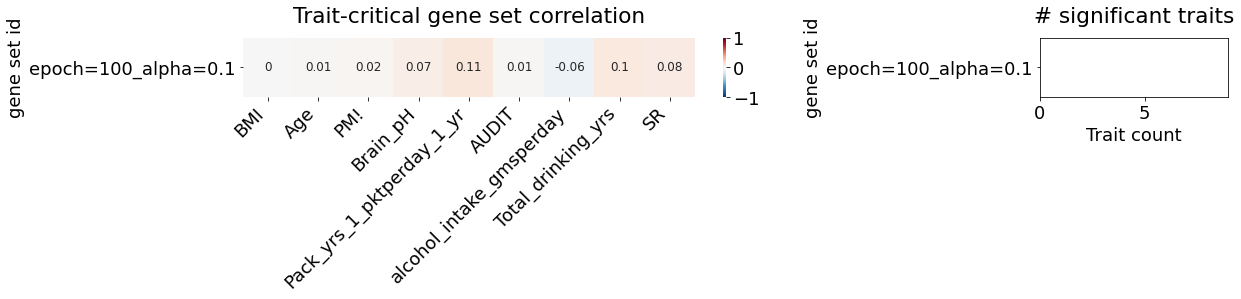

In [34]:
# Plot correlation of top critical genes (with most nearby impact genes) for each embedding
gene_set_phenotype_corr([critical_gene_set2], [emb_name], expression_meta_df, 'top 10 genes')

# Gene ID conversion

In [4]:
gene_mapping_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/gene_mapping_df.csv')

In [5]:
critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/epoch=100_alpha=0.1_critical_gene_df.csv')

In [57]:
gene_mapping_df.head()

,id,symbol
0,ENSG00000227232,WASH7P
1,ENSG00000237683,NaN
2,ENSG00000241860,AL627309.5
3,ENSG00000228463,AP006222.1
4,ENSG00000225972,MTND1P23


In [8]:
gene_mapping_dict = pd.Series(gene_mapping_df['symbol'].values, index = gene_mapping_df['id']).to_dict()

In [9]:
converted_cg_df = critical_gene_df.copy()
converted_cg_df['gene'] = converted_cg_df['gene'].map(gene_mapping_dict)
converted_cg_df = converted_cg_df[~converted_cg_df['gene'].isna()]

Removing existing folder: output
Created folder output


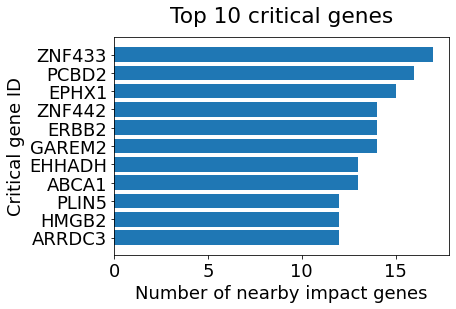

In [6]:
gene_set = plot_nearby_impact_num(converted_cg_df, 'Top 10 critical genes')

In [14]:
from src.eda.eda_functions import cluster_phenotype_corr, gene_phenotype_corr

## Plot alcohol trait and CG, neighbor and DEG correlation

In [6]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)

In [10]:
before19911 = expression_meta_df.columns[:19911].map(gene_mapping_dict)
after19911 = expression_meta_df.columns[19911:]
new_columns = list(before19911) + list(after19911)
expression_meta_df.columns = new_columns

In [16]:
cg_corr

,AUDIT,Alcohol_intake_gmsperday,Total_drinking_yrs
gene,,,
ZNF433,-0.016890,-0.105586,0.104595
PCBD2,0.115464,0.053217,-0.041172
EPHX1,0.112825,0.055354,-0.025599
GAREM2,0.148926,0.150258,-0.232543
ERBB2,0.059658,-0.017325,-0.021768
ZNF442,-0.039694,-0.075593,0.161016
ABCA1,-0.011675,-0.042717,0.038016
EHHADH,-0.015018,-0.041770,-0.049666
ARRDC3,0.020599,-0.034309,0.199938


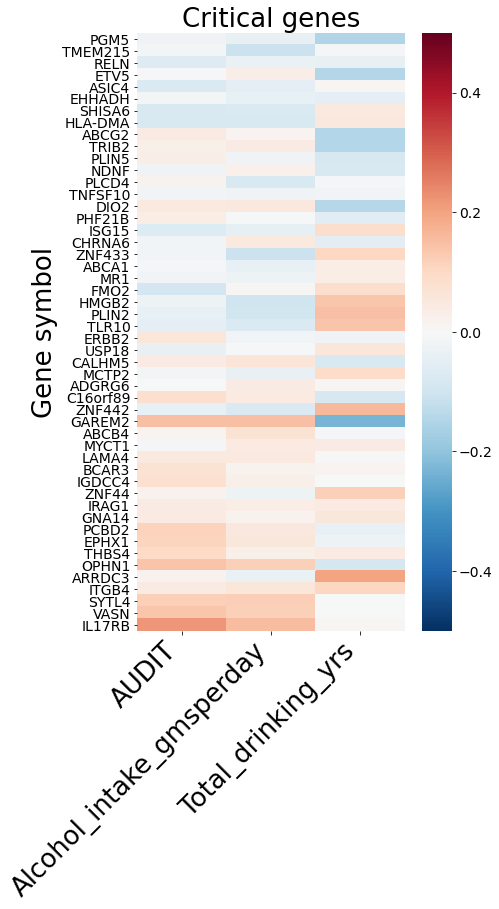

In [41]:
cg_corr = gene_phenotype_corr(converted_cg_df.gene[:50], expression_meta_df, 'Critical genes')

In [38]:
neighbors_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/top_830_neighbor_genes.csv')
neighbors_symbols = list(neighbors_df['gene'].map(gene_mapping_dict))

In [39]:
neighbors_symbols = [symbol for symbol in neighbors_symbols if type(symbol) == str]

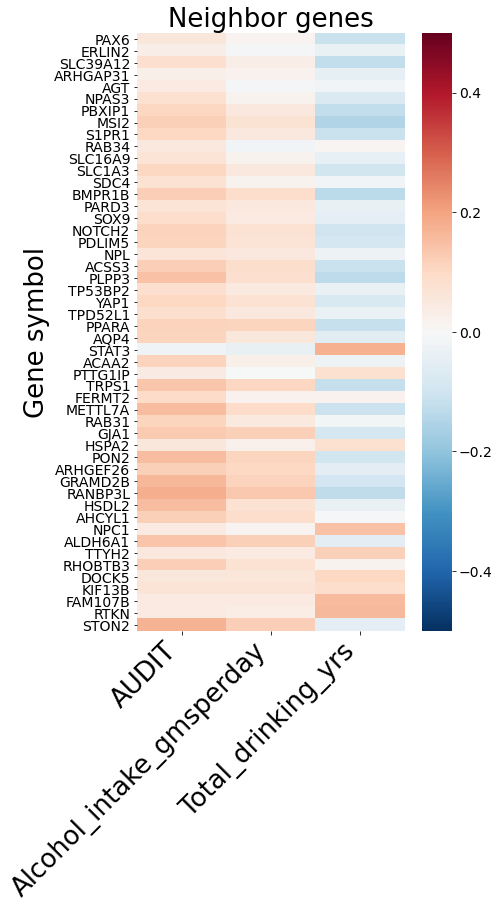

In [42]:
neighbor_corr = gene_phenotype_corr(neighbors_symbols[:50], expression_meta_df, 'Neighbor genes')

In [43]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])
deseq.sort_values('abs_log2FC', ascending = False, inplace = True)

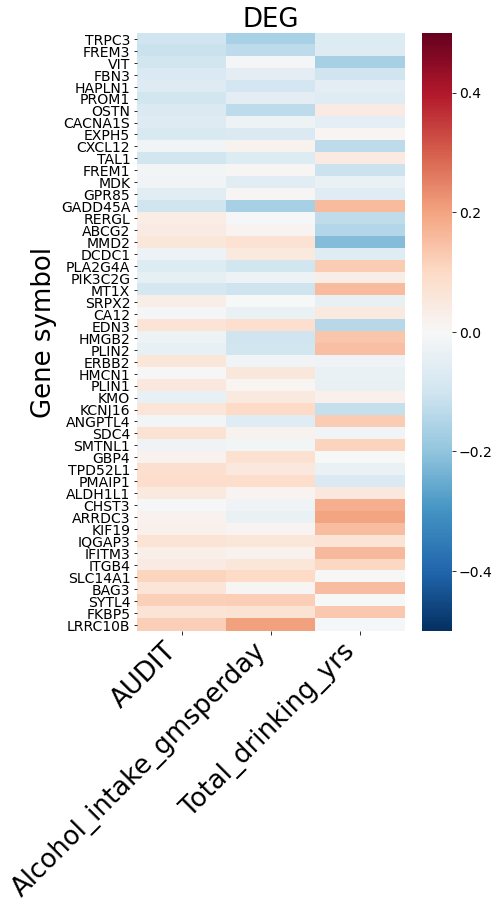

In [44]:
deg_corr = gene_phenotype_corr(deseq.gene[:50], expression_meta_df, 'DEG')

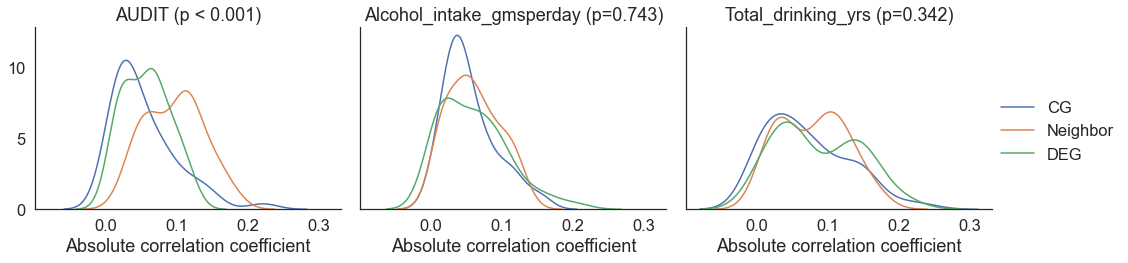

In [46]:
plot_corr_kde([cg_corr, neighbor_corr, deg_corr], ['CG', 'Neighbor', 'DEG'], 'alcohol trait')

In [51]:
for col in cg_corr.columns:
    cg = pd.DataFrame(cg_corr[col].values)
    cg['gene_list'] = 'cg'
    ng = pd.DataFrame(neighbor_corr[col].values)
    ng['gene_list'] = 'neighbor'
    deg = pd.DataFrame(deg_corr[col].values)
    deg['gene_list'] = 'deg'
    joined = pd.concat([cg, ng, deg]).reset_index(drop = True)
    print('alcohol trait', col)
    comp = pairwise_tukeyhsd(endog=joined[0], groups=joined['gene_list'], alpha=0.05)
    print(comp)

alcohol trait AUDIT
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower  upper  reject
----------------------------------------------------
    cg      deg  -0.0215 0.178 -0.0499  0.007  False
    cg neighbor    0.075 0.001  0.0465 0.1034   True
   deg neighbor   0.0964 0.001   0.068 0.1249   True
----------------------------------------------------
alcohol trait Alcohol_intake_gmsperday
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
    cg      deg  -0.0101 0.6877 -0.0399 0.0198  False
    cg neighbor   0.0516  0.001  0.0217 0.0814   True
   deg neighbor   0.0616  0.001  0.0318 0.0915   True
-----------------------------------------------------
alcohol trait Total_drinking_yrs
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------

# CG, Neighbor and DEG overlap

In [21]:
len(set(critical_gene_df.gene) - set(deg) - set(neighbors_df.gene))

724

In [26]:
len(set(critical_gene_df.gene).intersection(set(neighbors_df.gene)))

80

In [28]:
len(set(critical_gene_df.gene)-(set(neighbors_df.gene)))

749

In [29]:
829-80

749

In [23]:
len(critical_gene_df.gene)

829

In [17]:
deg = deseq[deseq['padj'] < 0.05].id

In [18]:
len(deg)

117